# Подготовка модели распознавания рукописных букв и цифр

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import EMNIST

### Загрузка и визуализация данных

In [13]:
train_dataset = EMNIST('data/', 'balanced', train=True, download=False)
val_dataset = EMNIST('data/', 'balanced', train=False, download=False)

with open('emnist-balanced-mapping.txt', 'r') as file:
    content = file.read()
lines = content.strip().split('\n')
labels_dict = {int(lines[i].split(' ')[0]): chr(int(lines[i].split(' ')[1])) for i in range(len(lines))}

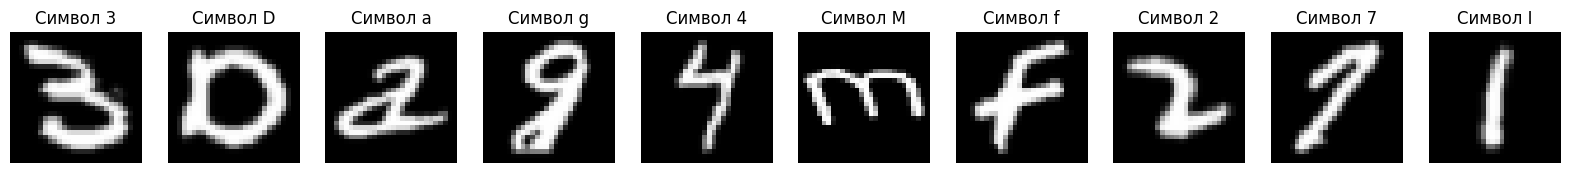

In [22]:
fig, ax = plt.subplots(1, 10, figsize=(20, 12))
rand_numbers = [random.randint(1, 112800) for _ in range(10)]
for i in range(10):
    # Загружаем изображение
    image = train_dataset[rand_numbers[i]][0]
    # Преобразуем в массив NumPy
    image_array = np.array(image)
    # Приводим к типу данных uint8, если это необходимо
    if image_array.dtype != np.uint8:
        image_array = image_array.astype(np.uint8)
    # Преобразуем обратно в объект Image
    pil_image = Image.fromarray(image_array)
    # Отзеркаливаем и поворачиваем на 270 градусов
    transformed_image = pil_image.transpose(Image.FLIP_LEFT_RIGHT).rotate(90)
    # Отображаем преобразованное изображение
    ax[i].imshow(transformed_image, cmap='gray')
    ax[i].set_title(f'Символ {labels_dict[train_dataset[rand_numbers[i]][1]]}')
    ax[i].axis('off')
plt.show()

### Подготовка данных для обучения и валидации

In [23]:
transform = Compose([
    ToTensor(),
    Normalize([0.5], [0.5])
])

#Normalize([0.1307], [0.3081])])
train_dataset = EMNIST('data/', 'balanced', train=True, download=False, transform=transform)
val_dataset = EMNIST('data/', 'balanced', train=False, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

### Определение модели

In [5]:
class CNN(nn.Module):
    def __init__(self, n_classes=47):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1), #(batch_size, 1, 28, 28) -> (batch_size, 32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), #(batch_size, 1, 28, 28) -> (batch_size, 32, 14, 14)
            nn.Conv2d(32, 64, (3, 3)), #(batch_size, 32, 14, 14) -> (batch_size, 64, 12, 12)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), #(batch_size, 64, 12, 12) -> (batch_size, 64, 6, 6)
            nn.Flatten(), #(batch_size, 64, 6, 6) -> (batch_size, 64*6*6)
            nn.Linear(64*6*6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )
       
    def forward(self, x):
        return self.model(x) 

### Определение функций обучения и валидации

In [6]:
def train(model, optimizer, loss_fn, train_loader, val_loader, n_epoch, val_fre):
    
    model.train()
    for epoch in range(1, n_epoch + 1):
        loss_sum = 0
        print(f'Epoch: {epoch}')
        for step, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data).squeeze(1)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

            if step % 10 == 0:
                print(f'Iter: {step} \tLoss: {loss.item()}')

        print(f'Mean Train Loss: {loss_sum / (step + 1):.6f}', end='\n\n')

        if epoch % val_fre == 0:
            validate(model, val_loader, epoch)

def validate(model, val_loader, epoch):
        
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (data, target) in enumerate(val_loader):
        with torch.no_grad():
            output = model(data).squeeze(1)
            loss = loss_fn(output, target)
        loss_sum += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(val_loader.dataset)
    
    mean_val_loss = loss_sum / (step + 1)
    
    if epoch > 19:
        torch.save(model.state_dict(), f'myapp/cnn_epoch_{epoch}.pth')
        print(f'На эпохе {epoch} параметры модели были сохранены при наилучшем значении функции потерь {mean_val_loss:.6f} на валидационной выборке.')
        print(f'Метрика Accuracy: {acc:.4f}.')
    else:    
        print(f'Функция потерь: {mean_val_loss:.6f} \tМетрика Accuracy: {acc:.4f}')
    model.train()

In [7]:
clf = CNN()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(clf.parameters(), lr=0.0001)
n_epoch = 50
val_fre = 2

In [8]:
train(clf, opt, loss_fn, train_loader, val_loader, n_epoch, val_fre)

Epoch: 1
Iter: 0 	Loss: 3.8630881309509277
Iter: 10 	Loss: 3.6936886310577393
Iter: 20 	Loss: 3.4655020236968994
Iter: 30 	Loss: 3.1371896266937256
Iter: 40 	Loss: 2.8021957874298096
Iter: 50 	Loss: 2.521700620651245
Iter: 60 	Loss: 2.174967050552368
Iter: 70 	Loss: 1.9260386228561401
Iter: 80 	Loss: 1.7059649229049683
Iter: 90 	Loss: 1.5659701824188232
Iter: 100 	Loss: 1.4689857959747314
Iter: 110 	Loss: 1.3487508296966553
Mean Train Loss: 2.474950

Epoch: 2
Iter: 0 	Loss: 1.363053321838379
Iter: 10 	Loss: 1.3346525430679321
Iter: 20 	Loss: 1.1979644298553467
Iter: 30 	Loss: 1.157373309135437
Iter: 40 	Loss: 1.0754873752593994
Iter: 50 	Loss: 1.087091326713562
Iter: 60 	Loss: 1.0134202241897583
Iter: 70 	Loss: 0.9680559039115906
Iter: 80 	Loss: 0.9245510101318359
Iter: 90 	Loss: 0.9484687447547913
Iter: 100 	Loss: 0.8933885097503662
Iter: 110 	Loss: 0.8775910139083862
Mean Train Loss: 1.051124

Функция потерь: 0.737435 	Метрика Accuracy: 0.7835
Epoch: 3
Iter: 0 	Loss: 0.88876456022262

Iter: 0 	Loss: 0.33865049481391907
Iter: 10 	Loss: 0.3544960916042328
Iter: 20 	Loss: 0.3385864198207855
Iter: 30 	Loss: 0.35165801644325256
Iter: 40 	Loss: 0.3764191269874573
Iter: 50 	Loss: 0.3360508382320404
Iter: 60 	Loss: 0.3869101405143738
Iter: 70 	Loss: 0.31177759170532227
Iter: 80 	Loss: 0.35555726289749146
Iter: 90 	Loss: 0.3547576069831848
Iter: 100 	Loss: 0.3838747441768646
Iter: 110 	Loss: 0.3943009376525879
Mean Train Loss: 0.357296

Функция потерь: 0.358408 	Метрика Accuracy: 0.8748
Epoch: 19
Iter: 0 	Loss: 0.34337303042411804
Iter: 10 	Loss: 0.3031315803527832
Iter: 20 	Loss: 0.3245523273944855
Iter: 30 	Loss: 0.375093549489975
Iter: 40 	Loss: 0.3574959635734558
Iter: 50 	Loss: 0.3796074390411377
Iter: 60 	Loss: 0.31170910596847534
Iter: 70 	Loss: 0.3481917977333069
Iter: 80 	Loss: 0.3456479012966156
Iter: 90 	Loss: 0.3633708953857422
Iter: 100 	Loss: 0.34095197916030884
Iter: 110 	Loss: 0.3676408529281616
Mean Train Loss: 0.348403

Epoch: 20
Iter: 0 	Loss: 0.3626813292

Iter: 60 	Loss: 0.30469536781311035
Iter: 70 	Loss: 0.28850823640823364
Iter: 80 	Loss: 0.2721482217311859
Iter: 90 	Loss: 0.2834758460521698
Iter: 100 	Loss: 0.30111926794052124
Iter: 110 	Loss: 0.2660076320171356
Mean Train Loss: 0.285044

Epoch: 34
Iter: 0 	Loss: 0.2826027572154999
Iter: 10 	Loss: 0.26787033677101135
Iter: 20 	Loss: 0.30761468410491943
Iter: 30 	Loss: 0.2772931456565857
Iter: 40 	Loss: 0.2849460542201996
Iter: 50 	Loss: 0.25456342101097107
Iter: 60 	Loss: 0.26610004901885986
Iter: 70 	Loss: 0.2323480099439621
Iter: 80 	Loss: 0.2706603407859802
Iter: 90 	Loss: 0.26425862312316895
Iter: 100 	Loss: 0.3316211998462677
Iter: 110 	Loss: 0.2533457279205322
Mean Train Loss: 0.280629

На эпохе 34 параметры модели были сохранены при наилучшем значении функции потерь 0.330704 на валидационной выборке.
Метрика Accuracy: 0.8853.
Epoch: 35
Iter: 0 	Loss: 0.27651166915893555
Iter: 10 	Loss: 0.25948768854141235
Iter: 20 	Loss: 0.29573512077331543
Iter: 30 	Loss: 0.2340312898159027


На эпохе 48 параметры модели были сохранены при наилучшем значении функции потерь 0.327285 на валидационной выборке.
Метрика Accuracy: 0.8869.
Epoch: 49
Iter: 0 	Loss: 0.19731095433235168
Iter: 10 	Loss: 0.24725136160850525
Iter: 20 	Loss: 0.18985193967819214
Iter: 30 	Loss: 0.2535927891731262
Iter: 40 	Loss: 0.2098211944103241
Iter: 50 	Loss: 0.23193489015102386
Iter: 60 	Loss: 0.2712797224521637
Iter: 70 	Loss: 0.23815904557704926
Iter: 80 	Loss: 0.2648496925830841
Iter: 90 	Loss: 0.22669385373592377
Iter: 100 	Loss: 0.2605797350406647
Iter: 110 	Loss: 0.22014251351356506
Mean Train Loss: 0.233717

Epoch: 50
Iter: 0 	Loss: 0.23237432539463043
Iter: 10 	Loss: 0.2434602677822113
Iter: 20 	Loss: 0.2288803607225418
Iter: 30 	Loss: 0.2329430878162384
Iter: 40 	Loss: 0.23656155169010162
Iter: 50 	Loss: 0.24300113320350647
Iter: 60 	Loss: 0.21035626530647278
Iter: 70 	Loss: 0.2304389327764511
Iter: 80 	Loss: 0.21095521748065948
Iter: 90 	Loss: 0.2573994994163513
Iter: 100 	Loss: 0.224263206

In [9]:
clf.load_state_dict(torch.load('myapp/cnn_epoch_46.pth'))

C:\Users\user\AppData\Local\Temp\ipykernel_4172\1131203044.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clf.load_state_dict(torch.load('myapp/cnn_epoch_46.pth'))


<All keys matched successfully>

In [10]:
clf.eval()
correct = 0
for step, (data, target) in enumerate(val_loader):
    with torch.no_grad():
        output = clf(data).squeeze(1)
        loss = loss_fn(output, target)
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
acc = correct / len(val_loader.dataset)
print(f'Метрика Accuracy на валидационной выборке {acc:.4f}')

Метрика Accuracy на валидационной выборке 0.8866


In [11]:
torch.save(clf.state_dict(), 'myapp/model.ckpt')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import EMNIST
from PIL import Image
train_dataset = EMNIST('data/', 'balanced', train=True, download=False)
val_dataset = EMNIST('data/', 'balanced', train=False, download=False)

with open('emnist-balanced-mapping.txt', 'r') as file:
    content = file.read()
lines = content.strip().split('\n')
labels_dict = {int(lines[i].split(' ')[0]): chr(int(lines[i].split(' ')[1])) for i in range(len(lines))}
fig, ax = plt.subplots(1, 10, figsize=(20, 12))
rand_numbers = [random.randint(1, 112800) for _ in range(10)]
for i in range(10):
    image = train_dataset[rand_numbers[i]][0]
    image_array = np.array(image)
    if image_array.dtype != np.uint8:
        image_array = image_array.astype(np.uint8)
    pil_image = Image.fromarray(image_array)
    transformed_image = pil_image.transpose(Image.FLIP_LEFT_RIGHT).rotate(90)
    ax[i].imshow(transformed_image, cmap='gray')
    ax[i].set_title(f'Символ {labels_dict[train_dataset[rand_numbers[i]][1]]}')
    ax[i].axis('off')
plt.show()
transform = Compose([
    ToTensor(),
    Normalize([0.5], [0.5]) 
]) #Normalize 0.1307, 0.3081

train_dataset = EMNIST('data/', 'balanced', train=True, download=False, transform=transform)
val_dataset = EMNIST('data/', 'balanced', train=False, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
class CNN(nn.Module):
    def __init__(self, n_classes=47):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1), #(batch_size, 1, 28, 28) -> (batch_size, 32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), #(batch_size, 1, 28, 28) -> (batch_size, 32, 14, 14)
            nn.Conv2d(32, 64, (3, 3)), #(batch_size, 32, 14, 14) -> (batch_size, 64, 12, 12)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), #(batch_size, 64, 12, 12) -> (batch_size, 64, 6, 6)
            nn.Flatten(), #(batch_size, 64, 6, 6) -> (batch_size, 64*6*6)
            nn.Linear(64*6*6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )
       
    def forward(self, x):
        return self.model(x)
def train(model, optimizer, loss_fn, train_loader, val_loader, n_epoch, val_fre):
    model.train()
    for epoch in range(1, n_epoch + 1):
        loss_sum = 0
        print(f'Epoch: {epoch}')
        for step, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data).squeeze(1)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            if step % 10 == 0:
                print(f'Iter: {step} \tLoss: {loss.item()}')
        print(f'Mean Train Loss: {loss_sum / (step + 1):.6f}', end='\n\n')
        if epoch % val_fre == 0:
            validate(model, val_loader, epoch)
def validate(model, val_loader, epoch):
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (data, target) in enumerate(val_loader):
        with torch.no_grad():
            output = model(data).squeeze(1)
            loss = loss_fn(output, target)
        loss_sum += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(val_loader.dataset)
    mean_val_loss = loss_sum / (step + 1)
    if epoch > 19:
        torch.save(model.state_dict(), f'myapp/cnn_epoch_{epoch}.pth')
        print(f'На эпохе {epoch} параметры модели были сохранены при наилучшем значении функции потерь {mean_val_loss:.6f} на валидационной выборке.')
        print(f'Метрика Accuracy: {acc:.4f}.')
    else:    
        print(f'Функция потерь: {mean_val_loss:.6f} \tМетрика Accuracy: {acc:.4f}')
    model.train()
clf = CNN()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(clf.parameters(), lr=0.0001)
n_epoch = 50
val_fre = 2
train(clf, opt, loss_fn, train_loader, val_loader, n_epoch, val_fre)
clf.load_state_dict(torch.load('myapp/cnn_epoch_50.pth'))
clf.eval()
correct = 0
for step, (data, target) in enumerate(val_loader):
    with torch.no_grad():
        output = clf(data).squeeze(1)
        loss = loss_fn(output, target)
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
acc = correct / len(val_loader.dataset)
print(f'Метрика Accuracy на валидационной выборке {acc:.4f}')
torch.save(clf.state_dict(), 'myapp/model.ckpt')

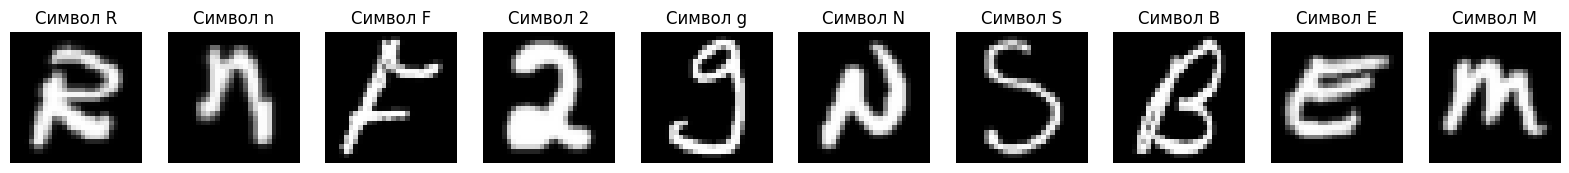

Epoch: 1
Iter: 0 	Loss: 3.8605456352233887
Iter: 10 	Loss: 3.7016854286193848
Iter: 20 	Loss: 3.4520459175109863
Iter: 30 	Loss: 3.1658060550689697
Iter: 40 	Loss: 2.8491146564483643
Iter: 50 	Loss: 2.5631697177886963
Iter: 60 	Loss: 2.2711222171783447
Iter: 70 	Loss: 2.011436700820923
Iter: 80 	Loss: 1.7919002771377563
Iter: 90 	Loss: 1.6534725427627563
Iter: 100 	Loss: 1.5021485090255737
Iter: 110 	Loss: 1.361965537071228
Mean Train Loss: 2.514846

Epoch: 2
Iter: 0 	Loss: 1.3746263980865479
Iter: 10 	Loss: 1.336456298828125
Iter: 20 	Loss: 1.2493172883987427
Iter: 30 	Loss: 1.122827172279358
Iter: 40 	Loss: 1.0453124046325684
Iter: 50 	Loss: 1.0772836208343506
Iter: 60 	Loss: 1.0017738342285156
Iter: 70 	Loss: 0.9617631435394287
Iter: 80 	Loss: 0.9498053193092346
Iter: 90 	Loss: 0.8528149127960205
Iter: 100 	Loss: 0.8817127346992493
Iter: 110 	Loss: 0.8659930229187012
Mean Train Loss: 1.062486

Функция потерь: 0.736975 	Метрика Accuracy: 0.7811
Epoch: 3
Iter: 0 	Loss: 0.7812387943267

Iter: 0 	Loss: 0.3981858491897583
Iter: 10 	Loss: 0.3416924476623535
Iter: 20 	Loss: 0.38013458251953125
Iter: 30 	Loss: 0.37722909450531006
Iter: 40 	Loss: 0.38289302587509155
Iter: 50 	Loss: 0.3681420385837555
Iter: 60 	Loss: 0.3140634596347809
Iter: 70 	Loss: 0.38518235087394714
Iter: 80 	Loss: 0.3843890130519867
Iter: 90 	Loss: 0.3511531352996826
Iter: 100 	Loss: 0.3213229477405548
Iter: 110 	Loss: 0.32747432589530945
Mean Train Loss: 0.361482

Функция потерь: 0.363897 	Метрика Accuracy: 0.8751
Epoch: 19
Iter: 0 	Loss: 0.3310393989086151
Iter: 10 	Loss: 0.36831340193748474
Iter: 20 	Loss: 0.3441631495952606
Iter: 30 	Loss: 0.39364105463027954
Iter: 40 	Loss: 0.34107622504234314
Iter: 50 	Loss: 0.3686365783214569
Iter: 60 	Loss: 0.37069812417030334
Iter: 70 	Loss: 0.3475568890571594
Iter: 80 	Loss: 0.33746322989463806
Iter: 90 	Loss: 0.3480554521083832
Iter: 100 	Loss: 0.3773530423641205
Iter: 110 	Loss: 0.5350496172904968
Mean Train Loss: 0.356305

Epoch: 20
Iter: 0 	Loss: 0.386877

Iter: 80 	Loss: 0.28593146800994873
Iter: 90 	Loss: 0.31132692098617554
Iter: 100 	Loss: 0.3105805218219757
Iter: 110 	Loss: 0.32556086778640747
Mean Train Loss: 0.293133

Epoch: 34
Iter: 0 	Loss: 0.28251439332962036
Iter: 10 	Loss: 0.3037332594394684
Iter: 20 	Loss: 0.22891730070114136
Iter: 30 	Loss: 0.25368165969848633
Iter: 40 	Loss: 0.2788260877132416
Iter: 50 	Loss: 0.2915094196796417
Iter: 60 	Loss: 0.2952800989151001
Iter: 70 	Loss: 0.26239097118377686
Iter: 80 	Loss: 0.3163638412952423
Iter: 90 	Loss: 0.2596750855445862
Iter: 100 	Loss: 0.2620835602283478
Iter: 110 	Loss: 0.23869021236896515
Mean Train Loss: 0.287394

На эпохе 34 параметры модели были сохранены при наилучшем значении потерь 0.334189 на валидационной выборке.
Метрика Accuracy: 0.8839.
Epoch: 35
Iter: 0 	Loss: 0.27540096640586853
Iter: 10 	Loss: 0.2870910167694092
Iter: 20 	Loss: 0.29025617241859436
Iter: 30 	Loss: 0.2838010787963867
Iter: 40 	Loss: 0.32073694467544556
Iter: 50 	Loss: 0.33080366253852844
Iter: 6

Iter: 0 	Loss: 0.2507753074169159
Iter: 10 	Loss: 0.21605733036994934
Iter: 20 	Loss: 0.2137233167886734
Iter: 30 	Loss: 0.23879222571849823
Iter: 40 	Loss: 0.24224629998207092
Iter: 50 	Loss: 0.23881858587265015
Iter: 60 	Loss: 0.22267916798591614
Iter: 70 	Loss: 0.22932428121566772
Iter: 80 	Loss: 0.2377668023109436
Iter: 90 	Loss: 0.2516225576400757
Iter: 100 	Loss: 0.23196546733379364
Iter: 110 	Loss: 0.15262669324874878
Mean Train Loss: 0.241844

Epoch: 50
Iter: 0 	Loss: 0.24700643122196198
Iter: 10 	Loss: 0.23915599286556244
Iter: 20 	Loss: 0.251346617937088
Iter: 30 	Loss: 0.23968999087810516
Iter: 40 	Loss: 0.22050774097442627
Iter: 50 	Loss: 0.2324219048023224
Iter: 60 	Loss: 0.23888228833675385
Iter: 70 	Loss: 0.25338971614837646
Iter: 80 	Loss: 0.2733427882194519
Iter: 90 	Loss: 0.24124933779239655
Iter: 100 	Loss: 0.24484390020370483
Iter: 110 	Loss: 0.32002323865890503
Mean Train Loss: 0.239686

На эпохе 50 параметры модели были сохранены при наилучшем значении потерь 0.32

C:\Users\user\AppData\Local\Temp\ipykernel_4172\2223977812.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clf.load_state_dict(torch.load('myapp/cnn_epoch_50.pth'))


Метрика Accuracy на валидационной выборке 0.8869


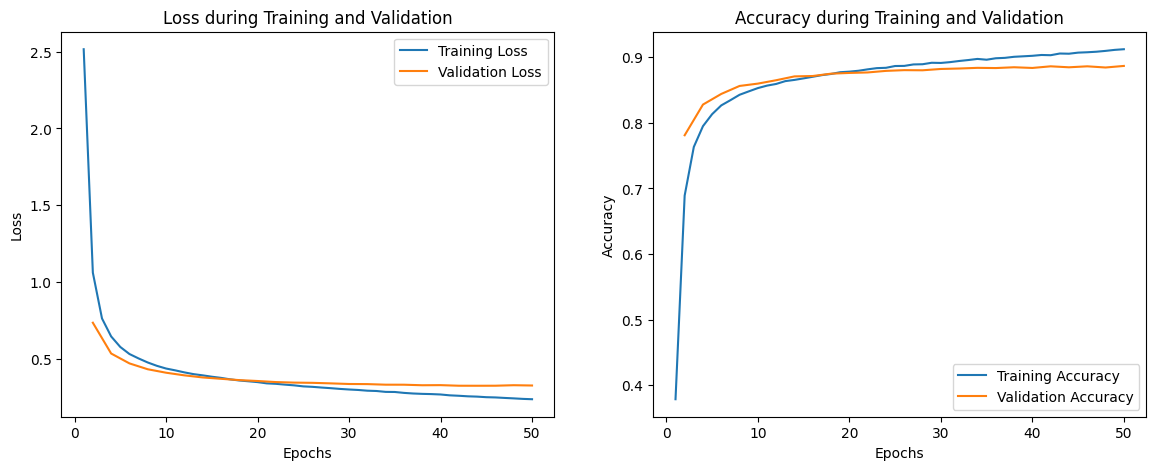

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import EMNIST
from PIL import Image

# Загрузка данных EMNIST
train_dataset = EMNIST('data/', 'balanced', train=True, download=False)
val_dataset = EMNIST('data/', 'balanced', train=False, download=False)

# Загрузка меток
with open('emnist-balanced-mapping.txt', 'r') as file:
    content = file.read()
lines = content.strip().split('\n')
labels_dict = {int(lines[i].split(' ')[0]): chr(int(lines[i].split(' ')[1])) for i in range(len(lines))}

# Визуализация некоторых образцов
fig, ax = plt.subplots(1, 10, figsize=(20, 12))
rand_numbers = [random.randint(1, 112800) for _ in range(10)]
for i in range(10):
    image = train_dataset[rand_numbers[i]][0]
    image_array = np.array(image)
    if image_array.dtype != np.uint8:
        image_array = image_array.astype(np.uint8)
    pil_image = Image.fromarray(image_array)
    transformed_image = pil_image.transpose(Image.FLIP_LEFT_RIGHT).rotate(90)
    ax[i].imshow(transformed_image, cmap='gray')
    ax[i].set_title(f'Символ {labels_dict[train_dataset[rand_numbers[i]][1]]}')
    ax[i].axis('off')
plt.show()

# Преобразование данных
transform = Compose([
    ToTensor(),
    Normalize([0.5], [0.5]) 
]) 

train_dataset = EMNIST('data/', 'balanced', train=True, download=False, transform=transform)
val_dataset = EMNIST('data/', 'balanced', train=False, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

# Определение модели
class CNN(nn.Module):
    def __init__(self, n_classes=47):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, (3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*6*6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.model(x)

# Списки для хранения потерь и точности
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train(model, optimizer, loss_fn, train_loader, val_loader, n_epoch, val_fre):
    model.train()
    for epoch in range(1, n_epoch + 1):
        loss_sum = 0
        correct = 0
        print(f'Epoch: {epoch}')
        for step, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data).squeeze(1)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

            # Вычисление точности на тренировочной выборке
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            if step % 10 == 0:
                print(f'Iter: {step} \tLoss: {loss.item()}')

        mean_train_loss = loss_sum / (step + 1)
        train_losses.append(mean_train_loss)
        train_accuracies.append(correct / len(train_loader.dataset))

        print(f'Mean Train Loss: {mean_train_loss:.6f}', end='\n\n')

        if epoch % val_fre == 0:
            validate(model, val_loader, epoch)

def validate(model, val_loader, epoch):
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (data, target) in enumerate(val_loader):
        with torch.no_grad():
            output = model(data).squeeze(1)
            loss = loss_fn(output, target)
        loss_sum += loss.item()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    acc = correct / len(val_loader.dataset)
    mean_val_loss = loss_sum / (step + 1)
    val_losses.append(mean_val_loss)
    val_accuracies.append(acc)

    if epoch > 19:
        torch.save(model.state_dict(), f'myapp/cnn_epoch_{epoch}.pth')
        print(f'На эпохе {epoch} параметры модели были сохранены при наилучшем значении потерь {mean_val_loss:.6f} на валидационной выборке.')
        print(f'Метрика Accuracy: {acc:.4f}.')
    else:    
        print(f'Функция потерь: {mean_val_loss:.6f} \tМетрика Accuracy: {acc:.4f}')
    model.train()

# Инициализация модели и параметров обучения
clf = CNN()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(clf.parameters(), lr=0.0001)
n_epoch = 50
val_fre = 2

# Обучение модели
train(clf, opt, loss_fn, train_loader, val_loader, n_epoch, val_fre)

# Проводим финальную валидацию
clf.load_state_dict(torch.load('myapp/cnn_epoch_50.pth'))
clf.eval()
correct = 0
for step, (data, target) in enumerate(val_loader):
    with torch.no_grad():
        output = clf(data).squeeze(1)
        loss = loss_fn(output, target)
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
acc = correct / len(val_loader.dataset)
print(f'Метрика Accuracy на валидационной выборке {acc:.4f}')

# Сохранение модели
torch.save(clf.state_dict(), 'myapp/model.ckpt')

# Визуализация метрик
plt.figure(figsize=(14, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epoch + 1), train_losses, label='Training Loss')
plt.plot(range(val_fre, n_epoch + 1, val_fre), val_losses, label='Validation Loss')
plt.title('Loss during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epoch + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(val_fre, n_epoch + 1, val_fre), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
